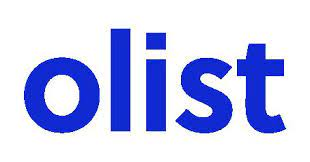

# <a name = "sommaire"> Sommaire 

- <a href ="#id_app"> Présentation du projet </a>
- <a href ="#fonction"> Fonction visualisation </a>
- <a href ="#import"> Importation des bibliothèques et des données </a>
- <a href ="#reg"> Regroupement des jeux de données </a>
- <a href ="#desc"> Description du jeu de données </a>
- <a href ="#nett"> Nettoyage du jeu de données: </a>
    - <a href ="#nett_col"> Suppression des colonnes mal renseignées </a>
    - <a href ="#nett_col2"> Commande délivrée </a>
    - <a href ="#nett_col3"> Délais de livraison </a>
    - <a href ="#nett_col4"> Situer le client </a>
    - <a href ="#nett_col5"> Nombres d'achat par produit et par client </a>
    - <a href ="#nett_col6"> Nombres moyen d'articles par commande </a> 
    - <a href ="#nett_col7"> Nombres d'utilisations des différentes méthodes de paiements</a>
    - <a href ="#nett_col8"> Récence</a>
    - <a href ="#nett_col10"> Distance entre le client et le vendeur</a>
    - <a href ="#nett_col11"> Fréquence</a> 
    - <a href ="#nett_col12"> Variable additionnelle </a>
    - <a href ="#nett_col13"> Fichier client</a>
    - <a href ="#nett_col14"> Traitement des valeurs manquantes</a> 
- <a href ="#analyse1"> Analyse univariée
- <a href ="#analyse2"> Analyse bivariée

# <a name = "id_app"> Présentation du projet</a> <a href ="#sommaire"> Retour au sommaire</a>

Olist est une entreprise brésilienne qui propose une solution de vente sur les maketplaces en ligne souhaite faire une segmentation des clients qu'elle pourra ensuite utiliser au quotidien pour leurs campagnes de communication.

Ainsi l'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à  leurs données personnelles.

# <a name = "fonction"> Fonction visualisation</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
def dist_box_hist(df, name_col, title, color, ncols = 2, nrows = 2, squeeze=True):
  f, (ax_box, ax_hist) = plt.subplots(nrows, ncols, figsize = (17, 12),sharex = 'col', gridspec_kw={"height_ratios": [.12, .99]}, squeeze = squeeze)
  for i, name in enumerate(name_col):
    sns.boxplot(x = df[name], ax=ax_box[i], color=color[i])
    sns.histplot(data=df, x=name, ax=ax_hist[i], color = color[i])
    ax_box[i].set_title(title[i], size=15)
    ax_box[i].set_xlabel('')
    ax_hist[i].set_ylabel('Nombre de clients', size = 15)
    ax_hist[i].axvline(df[name].mean(), linestyle = '--', color='red')
    ax_hist[i].axvline(df[name].median(), linestyle = '--', color='blue')
    ymin, ymax = ax_hist[i].get_ylim()
    ax_hist[i].text(df[name].mean(), ymax - ymax*0.05, f' mean: {round(df[name].mean(), 2)}', color = 'red')
    ax_hist[i].text(df[name].median(), ymax - ymax*0.02, f' median: {round(df[name].median(), 2)}', color = 'blue')

# <a name = "import"> Importation des bibliothèques et des données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
!pip install matplotlib --upgrade &> /dev/null
!pip install yellowbrick &> /dev/null

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import radians
from sklearn.metrics.pairwise import haversine_distances
from datetime import datetime
import folium
from folium.plugins import MarkerCluster

import os
pd.set_option('display.max_columns', None)

In [ ]:
df_cust = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_customers_dataset.csv')
df_loc = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_order_items_dataset.csv')
df_order = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_orders_dataset.csv')
df_payments = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_order_payments_dataset.csv')
df_reviews = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_order_reviews_dataset.csv')
df_product = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_products_dataset.csv')
df_product_trans = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/product_category_name_translation.csv')
df_seller = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_sellers_dataset.csv')

# <a name = "import"> Regroupement des jeux de données</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour commencer ce projet qui est basé sur la segmentation de clients, on va dans un premier temps regrouper tous les jeux de données mis à notre disposition ([ici](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)) avec la fonction merge de pandas. Ici le fait de regrouper tous les fichiers dès le début va nous faciliter le nettoyage.

Ici on peut utiliser le schéma mis à notre disposition pour savoir comment les jeux de données sont reliés entre eux.

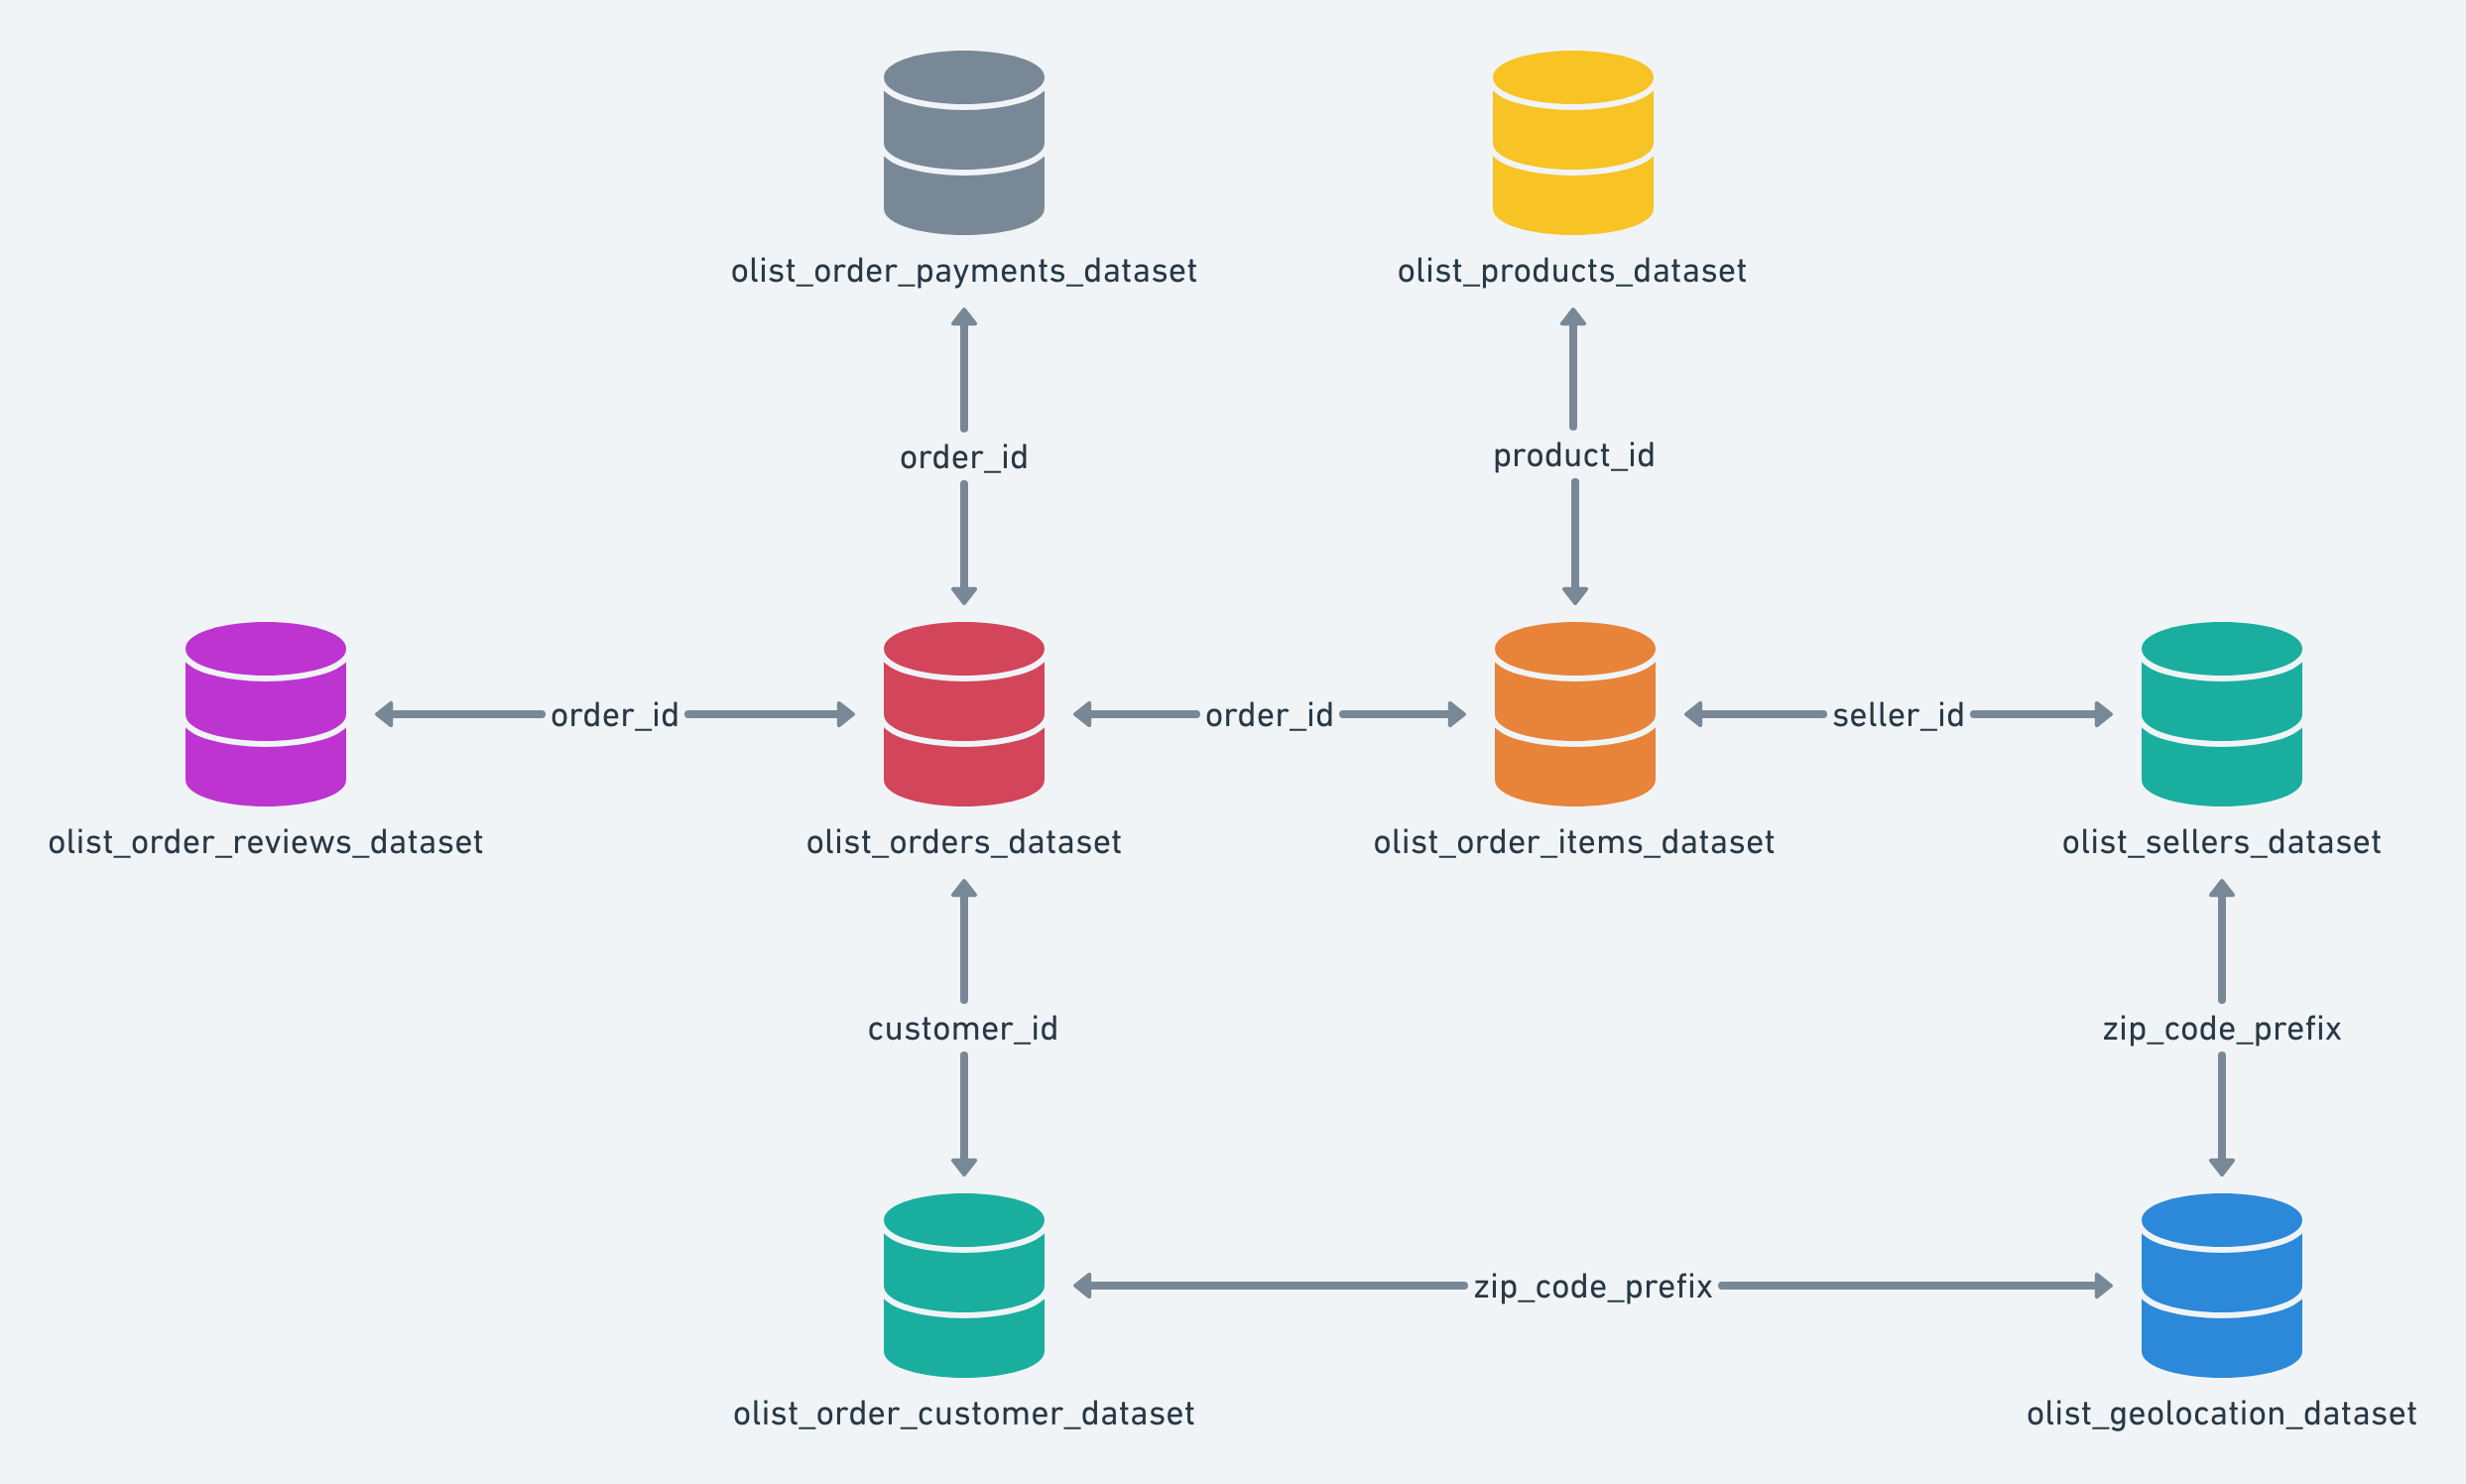

In [ ]:
df_loc.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Avant de commencer à regrouper tous les fichiers, on va s'occuper du dataset df_loc car si on regarde juste sur les 5 premières lignes, on remarque que le code postal 1046 apparaît plusieurs fois pour la même ville. Pour éviter d'avoir des répétitions lors de la fusion avec les autres datasets on va prendre la moyenne de la latitude et la longitude avec un groupby sur le code postal. Après ça on pourra regrouper tous les jeux de données.

In [ ]:
# moyenne sur la latitude et la longitude
df_loc_new = df_loc.groupby('geolocation_zip_code_prefix').agg({"geolocation_lat":'mean', 'geolocation_lng':'mean'}).reset_index()

# Regroupement de tous les jeux de données
df = df_order.merge(df_payments, on = 'order_id', how = 'left').merge(df_order_items, on = 'order_id').merge(df_reviews, on = 'order_id', how = 'left')\
  .merge(df_cust, on = 'customer_id').merge(df_loc_new, left_on = 'customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix')

# <a name = "desc"> Description du jeu de données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
# nombres de lignes et de colonnes
nb_row, nb_col = df.shape 

# Taux de remplissage moyen
fill_rate = str(round(df.notna().mean().mean() * 100, 2)) + '%'  

# Nombres de doublons 
#dup_data = df.duplicated(['OSEBuildingID']).sum()

columns_df_desc = ['Nombres de lignes', 'Nombres de colonnes', 'Taux de remplissage moyen']

df_desciption = pd.DataFrame(columns = columns_df_desc)
df_desciption['Nombres de lignes'] = [nb_row]
df_desciption['Nombres de colonnes'] = [nb_col] 
df_desciption['Taux de remplissage moyen'] = [fill_rate]
#df_desciption['Nombres de doublons'] = [dup_data]
df_desciption

,Nombres de lignes,Nombres de colonnes,Taux de remplissage moyen
0,117993,31,95.07%


# <a name = "nett"> Nettoyage du jeu de données</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "nett_col"> Suppression des colonnes mal renseignées</a> <a href ="#sommaire"> Retour au sommaire</a>

On va commencer ce nettoyage en s'occupant des colonnes mal renseignées en regardant le taux de remplissage par colonne.

In [ ]:
# Taux de remplissage par colonne
fill_rate_df = df.notnull().mean().sort_values(ascending = False).to_frame('taux_remplissage').reset_index()

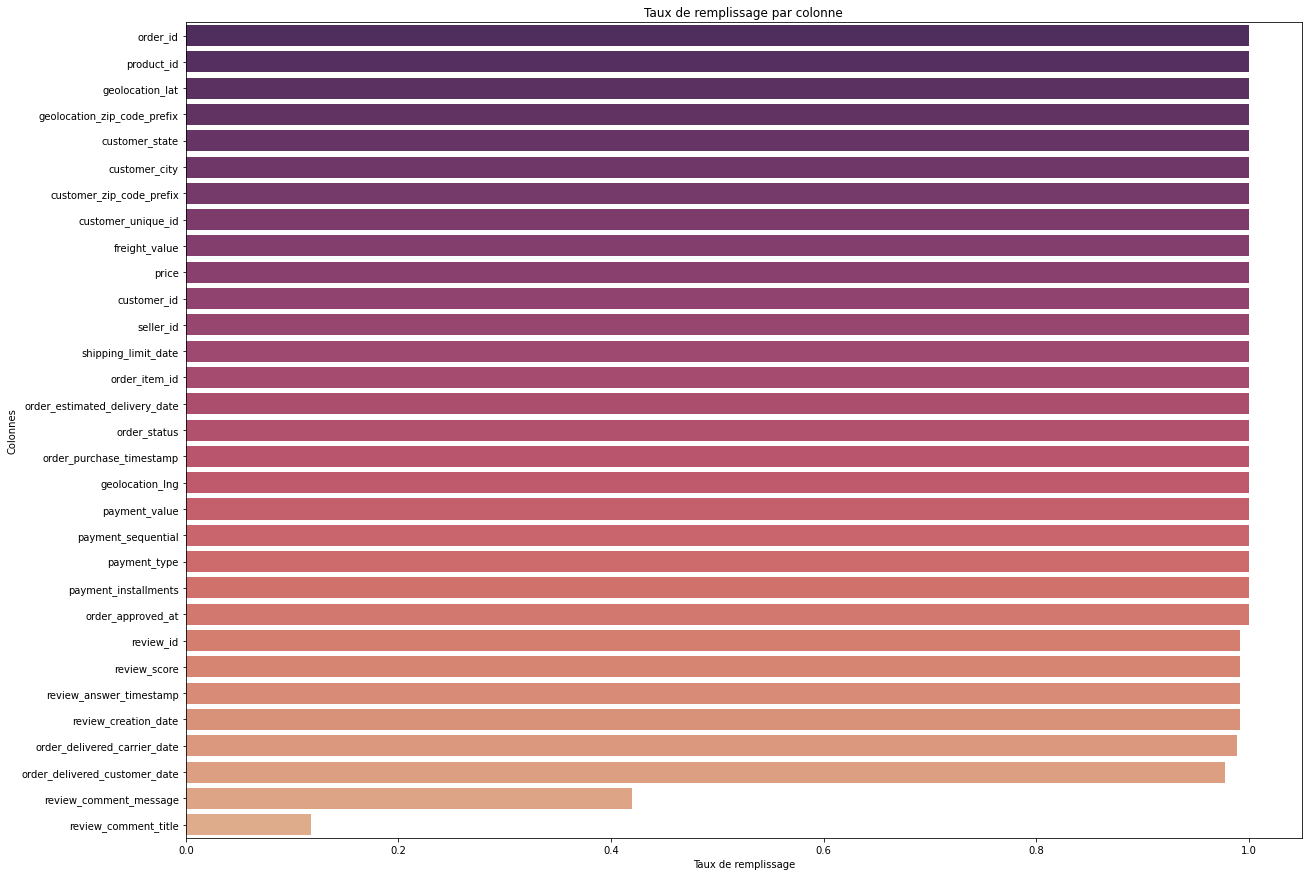

In [ ]:
# Visualisation du taux de remplissage
plt.figure(figsize = (20, 15))
sns.barplot(y='index', x='taux_remplissage', data = fill_rate_df, palette = "flare_r")
plt.title('Taux de remplissage par colonne')
plt.xlabel('Taux de remplissage')
plt.ylabel('Colonnes')
plt.show()

Toutes les colonnes sont très bien renseignées à part deux colonnes review_comment_message et review_comment_title qui vont renseignées sur le titre et le message du commentaire laissé, vu que c'est deux colonnes qui ne seront pas nécessaire pour la suite on va simplement les supprimer.

In [ ]:
drop_col1 = ['review_comment_message' , 'review_comment_title']
df.drop(drop_col1, axis = 1 , inplace = True)

### <a name = "nett_col2"> Commande délivrée</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour la suite du nettoyage on va se concentrer sur la variable order_status qui va renseigné sur le statut de la commande et donc on va avoir :
- 115 420 commandes qui ont bien été livrées
- 1248 commandes qui ont été expédiées
- 565 commandes qui ont été annulées
- 375 commandes qui sont en cours de traitement 
- 7 commandes qui sont indisponibles
- 3 commandes qui sont approuvées

Pour la suite on va continuer avec seulement les commandes qui ont été livrées.

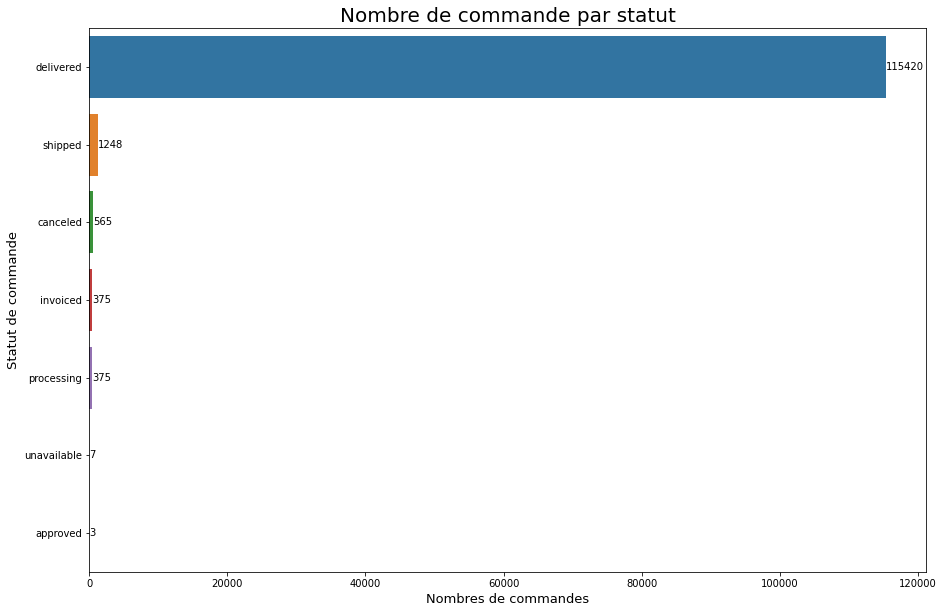

In [ ]:
# Nombre de commande par statut
count = df.order_status.value_counts().to_frame('count').reset_index()

# Visualisation
plt.figure(figsize = (15,10))
ax = sns.barplot(x = 'count', y = 'index', data = count)
plt.xlabel('Nombres de commandes', fontsize = 13)
plt.ylabel('Statut de commande', fontsize = 13)
plt.title('Nombre de commande par statut', fontsize = 20)
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
df = df.query('order_status == "delivered"').copy()

# Suppression de la colonne order_status 
df.drop('order_status', axis = 1 , inplace = True)

### <a name = "nett_col3"> Délais de livraison</a> <a href ="#sommaire"> Retour au sommaire</a>

Ici le but est d'ajouter une nouvelle variable qui représentera le délais de livraison de la commande en cours. Pour ça, on va prendre la différence entre le jour où le client a reçu sa commande et le jour ou le client à commander.

In [ ]:
# Changement de type pour les colonnes order_purchase_timestamp, order_delivered_customer_date, order_estimated_delivery_date en type datetime
df[['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = df[['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime)

# Délais de livraison
df['delivery_times'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

### <a name = "nett_col4"> Localisation des clients </a> <a href ="#sommaire"> Retour au sommaire</a>

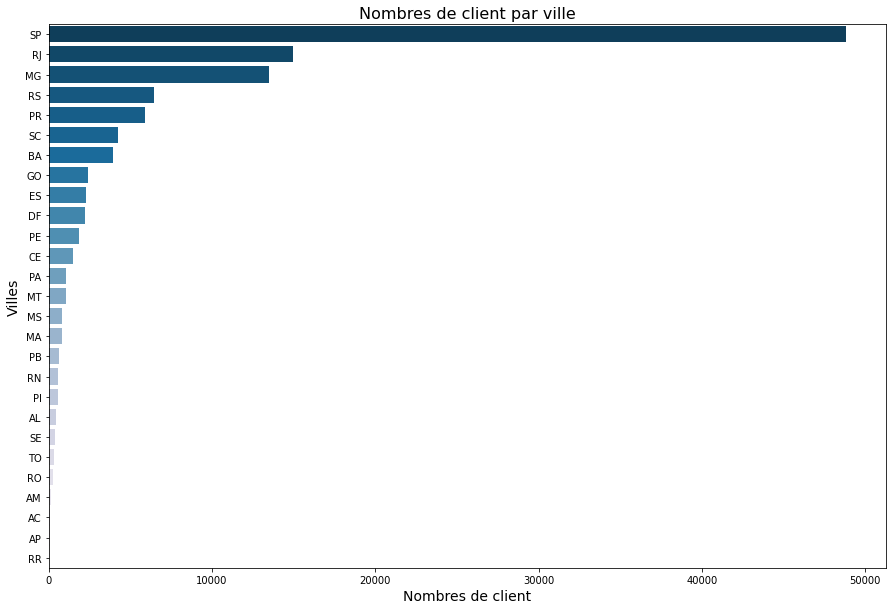

In [ ]:
city = df.customer_state.value_counts().to_frame('nb').reset_index()
plt.figure(figsize = (15,10))
sns.barplot(x = 'nb', y = 'index', data = city, palette = 'PuBu_r')
plt.title('Nombres de client par ville', fontsize = 16)
plt.xlabel('Nombres de client', fontsize = 14)
plt.ylabel('Villes', fontsize = 14)
plt.show()

Ici on peut voir que la majorité des clients proviennent du sud-est du Brésil. On va ajouter l'information à notre jeu de données d'où provient le client pour ça on va utiliser la longitude et la latitude disponible dans notre jeu de données et donc, on va utiliser la distance harvesine.

In [ ]:
brazil_centre = [-15.458295, -122.3320708] # Chapada dos Guimarães
seattle_centre_rad = [radians(_) for _ in brazil_centre]
distance = []
for i, row in df.iterrows():
   coord = [row.geolocation_lat, row.geolocation_lng]
   coord_rad = [radians(_) for _ in coord] 
   distance.append(round((haversine_distances([coord_rad, seattle_centre_rad]) * (6371000/1000))[0][1],3)) # Ici on multiplie par 6371000/1000 pour avoir la distance en km
df["Distance_km"]  = distance

 ### <a name = "nett_col5"> Nombres d'achat par produit et par client </a> <a href ="#sommaire"> Retour au sommaire</a>

Le but ici est de garder l'information de ce que le client a acheté et combien de fois. Afin de mieux connaître le client sur ses préferences d'achats et mieux le cibler.

On va commencer par fusionner le jeux de données df_product où on aura des informations sur le produit et le jeu de données initial et supprimer les colonnes qui nous seront pas nécessaires pour la suite comme :
- Le nom du produit en portugais
- Longueur, largueur et poids du produit
- La quantité de photos 

In [ ]:
df = df.merge(df_product, on = 'product_id').merge(df_product_trans, on = 'product_category_name')
df.drop(['product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], axis = 1, inplace = True)

In [ ]:
df.product_category_name_english.nunique()

71

On dispose de 71 catégories. Pour garder cette information et ne pas à avoir besoin de créer 71 colonnes en plus des colonnes qu'on a déjà dans notre jeu de données, on va essayer de regrouper certaines catégories commune en une même catégorie.

In [ ]:
replace_housewares = {'home_appliances':'housewares', 'home_appliances_2':'housewares', 'small_appliances':'housewares', 'small_appliances_home_oven_and_coffee':'housewares'}
repalce_mode = {'fashio_female_clothing':'mode', 'fashion_childrens_clothes':'mode', 'fashion_sport':'mode', 'fashion_male_clothing':'mode', 'fashion_underwear_beach':'mode', 'fashion_bags_accessories':'mode',
                'fashion_shoes':'mode', 'watches_gifts':'mode'}
replace_health_beauty = {'perfumery':'health_beauty'}
replace_multimedia = {'fixed_telephony':'multimedia', 'electronics':'multimedia', 'computers_accessories':'multimedia', 'consoles_games':'multimedia', 'dvds_blu_ray':'multimedia', 'computers':'multimedia', 'music':'multimedia',
                      'cds_dvds_musicals':'multimedia', 'cine_photo':'multimedia', 'audio':'multimedia', 'telephony':'multimedia', 'tablets_printing_image':'multimedia', 'audio':'multimedia'}
replace_furniture = {'bed_bath_table':'furniture', 'office_furniture':'furniture', 'furniture_decor':'furniture', 'furniture_living_room':'furniture', 'kitchen_dining_laundry_garden_furniture':'furniture', 'furniture_mattress_and_upholstery':'furniture',
                     'furniture_bedroom':'furniture', 'garden_tools':'furniture'}
replace_baby = {'diapers_and_hygiene':'baby', 'toys':'baby'}
replace_constuction = {'home_construction':'construction', 'la_cuisine':'construction', 'construction_tools_construction':'construction','construction_tools_lights':'construction', 'costruction_tools_tools':'construction',
                       'costruction_tools_garden':'construction', 'construction_tools_safety':'construction'}
replace_market = {'market_place':'market', 'food_drink':'market', 'food':'market', 'drinks':'market'}
replace_security = {'signaling_and_security':'security', 'security_and_services':'security'}
replace_art = {'arts_and_craftmanship':'art'}
replace_home_comfort = {'home_comfort_2':'home_comfort', 'home_confort':'home_comfort'}
replace_books = {'books_imported':'books', 'books_technical':'books', 'books_general_interest':'books'}
replace_industry = {'industry_commerce_and_business':'industry', 'agro_industry_and_commerce':'industry'}
replace_leisure = {'sports_leisure':'leisure', 'party_supplies':'leisure', 'christmas_supplies':'leisure', 'cool_stuff':'leisure', 'musical_instruments':'leisure'}
replace = [replace_housewares, repalce_mode, replace_health_beauty, replace_multimedia, replace_furniture, replace_baby, replace_constuction, replace_market, replace_art, replace_books, replace_home_comfort, replace_security, replace_industry, replace_books, replace_leisure]
for i in replace:
  df.product_category_name_english.replace(i, inplace = True)

In [ ]:
# Visualisation
nb_cat = df.product_category_name_english.value_counts().to_frame('count').reset_index()

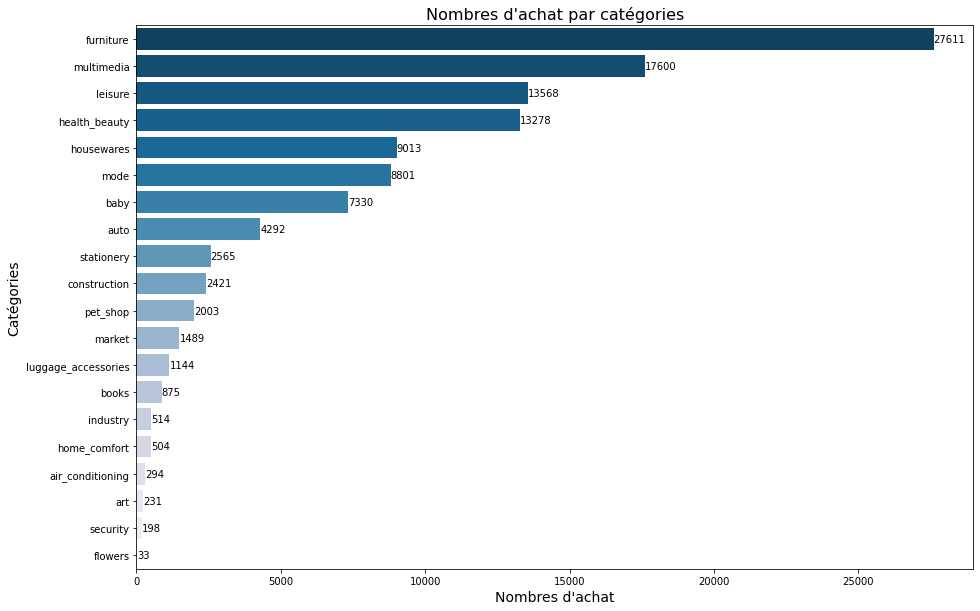

In [ ]:
plt.figure(figsize = (15, 10))
ax = sns.barplot(x='count', y = 'index', data = nb_cat,  palette = 'PuBu_r')
plt.xlabel("Nombres d'achat", fontsize = 14)
plt.ylabel("Catégories", fontsize = 14)
plt.title("Nombres d'achat par catégories", fontsize = 16)
ax.bar_label(ax.containers[0])
plt.show()

Avant de créer nos différentes colonnes, on va d'abord s'occuper des clients qui sur un article dans une commande ont payés en plusieurs fois et donc la même commande sera réprésentée n fois pour le même article.

Exemple:

In [ ]:
df.query('customer_unique_id == "7c396fd4830fd04220f754e42b4e5bff"')[['order_item_id', 'order_id', 'price', 'payment_value', 'payment_type','product_id', 'customer_unique_id','payment_sequential']].head(3)

,order_item_id,order_id,price,payment_value,payment_type,product_id,customer_unique_id,payment_sequential
0,1,e481f51cbdc54678b7cc49136f2d6af7,29.99,18.12,credit_card,87285b34884572647811a353c7ac498a,7c396fd4830fd04220f754e42b4e5bff,1.0
1,1,e481f51cbdc54678b7cc49136f2d6af7,29.99,2.00,voucher,87285b34884572647811a353c7ac498a,7c396fd4830fd04220f754e42b4e5bff,3.0
2,1,e481f51cbdc54678b7cc49136f2d6af7,29.99,18.59,voucher,87285b34884572647811a353c7ac498a,7c396fd4830fd04220f754e42b4e5bff,2.0


Par exemple, pour cette commande, ce client a 1 unique article dans sa commande qui est représentée par order_item_id, order_id et product_id mais cette commande est dupliquée en 3 fois car le client a payer en 3 fois ce même article représenté par payment_type et payment_sequential. Donc pour éviter de compter cette article 3 fois on va supprimer les commandes doublons par rapport au customer_unique_id, order_id et order_item_id.

In [ ]:
# Suppression des doublons
df_unique_item_id = df[~df.duplicated(['customer_unique_id', 'order_id', 'order_item_id'])]

# Nombres de produit acheter par catégorie et par client
nb_categories = df_unique_item_id.groupby(['customer_unique_id', 'product_category_name_english']).size().unstack().reset_index().fillna(0)

# Nombre total de produit acheter par client
nb_categories['nb_items'] = nb_categories.sum(axis = 1, numeric_only=True)
nb_categories.head()

product_category_name_english,customer_unique_id,air_conditioning,art,auto,baby,books,construction,flowers,furniture,health_beauty,home_comfort,housewares,industry,leisure,luggage_accessories,market,mode,multimedia,pet_shop,security,stationery,nb_items
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### <a name = "nett_col6"> Nombres moyen d'articles par commande </a> <a href ="#sommaire"> Retour au sommaire</a>

Ici on va ajouter le nombre moyen d'articles par commande, pour ça on va utiliser dans un premier temps un groupby sur customer_unique_id et order_id et compter le nombre d'article unique sur la colonne order_item_id et dans un second temps utiliser un nouveau groupby sur le customer_unique_id sur le résultat précedent en prenant la moyenne.

In [ ]:
mean_items = df.groupby(['customer_unique_id', 'order_id']).order_item_id.nunique().to_frame('nb_items').groupby(['customer_unique_id']).nb_items.mean().to_frame('mean_order').reset_index()
mean_items.head()

,customer_unique_id,mean_order
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0
2,0000f46a3911fa3c0805444483337064,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1.0
4,0004aac84e0df4da2b147fca70cf8255,1.0


### <a name = "nett_col7"> Nombres d'utilisations des différents méthode de paiements </a> <a href ="#sommaire"> Retour au sommaire</a>

Ici le but est de garder l'information concernant le type de paiement. Pour ça, on va créer 4 colonnes une pour chaque type de paiement et compter le nombre de fois où le client a utilisé ce type de paiement.

In [ ]:
nb_payment = df.payment_type.value_counts(dropna = False).to_frame('nb_payment').reset_index()
nb_payment.loc[nb_payment['index'].isnull(), 'index'] = 'Null'

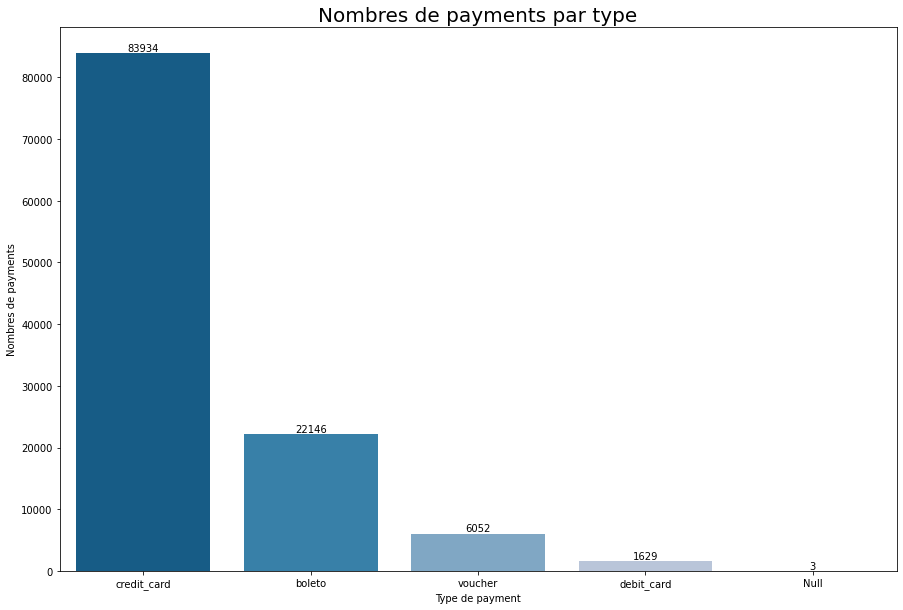

In [ ]:
plt.figure(figsize = (15, 10))
ax = sns.barplot(x = 'index', y = 'nb_payment', data = nb_payment, palette = 'PuBu_r')
plt.title('Nombres de payments par type', fontsize = 20)
plt.ylabel('Nombres de payments')
plt.xlabel('Type de payment')
ax.bar_label(ax.containers[0])
plt.show()

La majorité des clients utilise la cb et l'espèce pour payer leurs commandes. On remarque également qu'on a 3 valeurs manquantes qu'on va remplacer par "credit_card" qui est la valeur la plus fréquente.

In [ ]:
df.payment_type.fillna('credit_card', inplace = True)
type_payments = df.groupby(['customer_unique_id', 'payment_type']).size().unstack().reset_index().fillna(0)
type_payments.head()

payment_type,customer_unique_id,boleto,credit_card,debit_card,voucher
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,1.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,1.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,0.0,1.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,1.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,1.0,0.0,0.0


### <a name = "nett_col8"> Récence </a> <a href ="#sommaire"> Retour au sommaire</a>

Une des variables importante ici, tirée de la méthode de segmentation RFM. La récence va nous indiquer depuis combien de temps le client n'a plus acheté chez nous. Une personne qui a récemment acheté chez nous a plus de chance de recommander chez nous.

In [ ]:
recency = (df.order_purchase_timestamp.max() - df.groupby('customer_unique_id').order_purchase_timestamp.max()).dt.days.to_frame('Recency').reset_index()
recency.head()

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114
2,0000f46a3911fa3c0805444483337064,536
3,0000f6ccb0745a6a4b88665a16c9f078,320
4,0004aac84e0df4da2b147fca70cf8255,287


### <a name = "nett_col10"> Distance entre le client et le vendeur</a> <a href ="#sommaire"> Retour au sommaire</a>

Comme plus haut pour situer le client, on va également utiliser les coordonnées gps du vendeur afin de calculer la distance qui sépare le client et le vendeur.

In [ ]:
df_seller.drop(['seller_city', 'seller_state'], axis = 1, inplace = True)

df = df.merge(df_seller, on = 'seller_id')
df = df.merge(df_loc_new, left_on = 'seller_zip_code_prefix', right_on = 'geolocation_zip_code_prefix')

distance = []
for i, row in df.iterrows():
  seller_coord = [row.geolocation_lat_y, row.geolocation_lng_y]
  seller_coord_rad = [radians(_) for _ in seller_coord] 
  coord = [row.geolocation_lat_x, row.geolocation_lng_x]
  coord_rad = [radians(_) for _ in coord] 
  distance.append(round((haversine_distances([coord_rad, seller_coord_rad]) * (6371000/1000))[0][1],3)) # Ici on multiplie par 6371000/1000 pour avoir la distance en km
df["Distance_km_cut_seller"]  = distance

###<a name = "nett_col11"> Fréquence</a> <a href ="#sommaire"> Retour au sommaire</a>

Une autre variable importante ici tirée aussi de la méthode de segmentation RFM. La fréquence qui va nous indiquée le nombre d'achats réalisé sur la période. Plus un client achète régulièrement chez nous, plus il y a de chance pour qu'il achète à nouveau.

In [ ]:
frequency = df.groupby('customer_unique_id').agg({'order_id':'nunique',
                                      'Distance_km':'mean'})

###<a name = "nett_col12"> Variable additionnel</a> <a href ="#sommaire"> Retour au sommaire</a>

Ici le but est d'ajouter de nouvelle variable qui nous permetterons d'encore plus comprendre les différents type de clients et de mieux les cibler plus tard. Pour ça on va ajouter des variables comme :
- Le score moyen
- Mode de paiement moyen
- Paiement total
- Frais de port total
- Paiement en plusieurs fois moyen
- Délais de livraison moyen
- Distance client/vendeur moyen

In [ ]:
data = df.groupby(['customer_unique_id', 'order_id', 'order_item_id']).agg({'review_score':'mean', 
                                      'payment_installments':'max',
                                      'price':'mean',
                                      'freight_value':'mean',
                                      'payment_sequential':'max',
                                      'delivery_times':'mean',
                                      'Distance_km_cut_seller':'mean'}).groupby('customer_unique_id').agg({'review_score':'mean',
                                                                                                'payment_installments':'mean',
                                                                                                'price':'sum',
                                                                                                'freight_value':'sum',
                                                                                                'payment_sequential':'mean', 
                                                                                                'delivery_times':'mean',
                                                                                                'Distance_km_cut_seller':'mean'}).reset_index()

In [ ]:
data.head()

,customer_unique_id,review_score,payment_installments,price,freight_value,payment_sequential,delivery_times,Distance_km_cut_seller
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,8.0,129.90,12.00,1.0,6.0,110.569
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1.0,18.90,8.29,1.0,3.0,22.168
2,0000f46a3911fa3c0805444483337064,3.0,8.0,69.00,17.22,1.0,25.0,516.939
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,4.0,25.99,17.63,1.0,20.0,2481.287
4,0004aac84e0df4da2b147fca70cf8255,5.0,6.0,180.00,16.89,1.0,13.0,154.508


###<a name = "nett_col13"> Fichier client</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour finir cette partie nettoyage. On va créer le fichier final en fusionnant toutes les aggrégations créer précédemment.

In [ ]:
df_final = data.merge(recency, on = 'customer_unique_id')\
                .merge(nb_categories, on = 'customer_unique_id')\
                .merge(mean_items, on = 'customer_unique_id')\
                .merge(type_payments, on = 'customer_unique_id')\
                .merge(frequency, on = 'customer_unique_id')

On va ajouter deux nouvelles variables : 
- Le prix total moyen
- Le total dépensé qui est la dernière variable importante pour la méthode de segmentation RFM. Qui va représenter la somme des achats cumulés sur toute la période en incluant les frais de port.

In [ ]:
df_final['average_amount'] = df_final.price / df_final.nb_items
df_final['total_spend'] = df_final.price + df_final.freight_value
df_final.drop(['price'], axis = 1, inplace = True)

In [ ]:
df_final.head()

,customer_unique_id,review_score,payment_installments,freight_value,payment_sequential,delivery_times,Distance_km_cut_seller,Recency,air_conditioning,art,auto,baby,books,construction,flowers,furniture,health_beauty,home_comfort,housewares,industry,leisure,luggage_accessories,market,mode,multimedia,pet_shop,security,stationery,nb_items,mean_order,boleto,credit_card,debit_card,voucher,order_id,Distance_km,average_amount,total_spend
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,8.0,12.00,1.0,6.0,110.569,111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,7884.211,129.90,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1.0,8.29,1.0,3.0,22.168,114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,7884.666,18.90,27.19
2,0000f46a3911fa3c0805444483337064,3.0,8.0,17.22,1.0,25.0,516.939,536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1,7639.960,69.00,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,4.0,17.63,1.0,20.0,2481.287,320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,8238.335,25.99,43.62
4,0004aac84e0df4da2b147fca70cf8255,5.0,6.0,16.89,1.0,13.0,154.508,287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,7816.891,180.00,196.89


In [ ]:
df_final.shape

(91632, 38)

###<a name = "nett_col14">Traitement des valeurs manquantes</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
df_final.isnull().sum().to_frame('nb_null').reset_index().sort_values('nb_null', ascending = False).query('nb_null > 0') 

,index,nb_null
1,review_score,596
5,delivery_times,8
2,payment_installments,1
4,payment_sequential,1


On a quelques valeurs manquantes dans notre jeu de données final. Vu le faible nombre de valeurs manquantes, on va simplement remplacer par la médiane.

Avant d'imputer la variable review_score on va ajouter une nouvelle variable binaire qui représentera si le client a laisser un avis ou non.

In [ ]:
df_final['no_review'] = df_final.review_score.apply(lambda x: 1 if np.isnan(x) else 0)
df_final.fillna({'review_score': df_final.review_score.median(), 'payment_installments': df_final.payment_installments.median(), 'payment_sequential': df_final.payment_sequential.median(), 'delivery_times': df_final.delivery_times.median()}, inplace = True)

#<a name = "analyse1">Analyse univarie</a> <a href ="#sommaire"> Retour au sommaire</a>

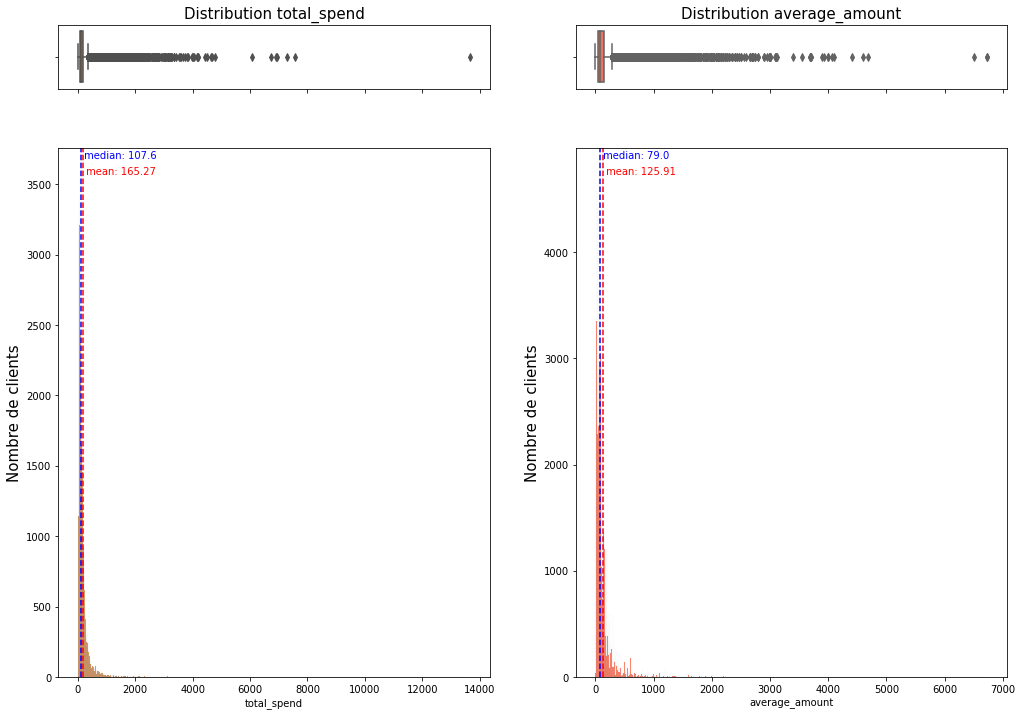

In [ ]:
name_col1 = ['total_spend', 'average_amount']
title1 = ['Distribution total_spend', 'Distribution average_amount']
colors1 =  ['peru', 'tomato']
dist_box_hist(df_final, name_col1, title1, colors1)

Pour la variable total_spend on va avoir :
- Un total d'achat allant de 9.59 Réal brésilien à 13 600. Ici la valeur extrème est seulement atypique, la personne a acheté 8 produits dans la catégorie multimédia d'où le fait d'avoir un total très élevé.
- Avec une moyenne d'achat de 165 RB et une médianne de 107 BR
- 50% des clients vont avoir un total d'achat qui va être compris entre 63 RB et 75 RB

Pour la variable average_amount on va avoir :
- Un total d'achat moyen allant de 0.85 RB à 6735. Ici aussi les deux valeurs extrèmes sont seulement atypique comme la plupart des clients ont 1 commande on se retrouve souvent avec une grosse commande.
- Avec une moyenne de 79 RB et une mediane de 125 RB
- 50 % des clients vont avoir un total d'achat moyen compris entre 42 RB et 140 RB

In [ ]:
# client = ['459bef486812aa25204be022145caa62', 'dc4802a71eae9be1dd28f5d788ceb526']
# df_final.loc[df_final['customer_unique_id'].isin(client), 'average_amount'] = np.nan
# df_final.loc[df_final['customer_unique_id'].isin(client), 'total_spend'] = np.nan
# df_final.fillna({'average_amount':df_final.average_amount.median(), 'total_spend' : df_final.total_spend.median()}, inplace = True)

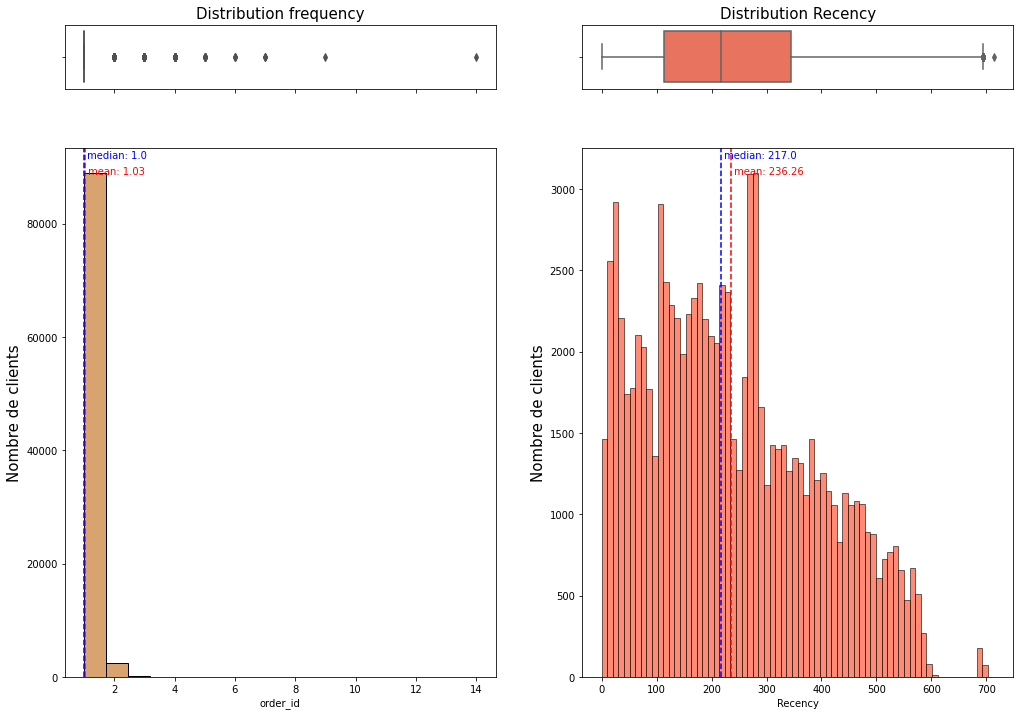

In [ ]:
name_col1 = ['order_id', 'Recency']
title1 = ['Distribution frequency', 'Distribution Recency']
colors1 =  ['peru', 'tomato']
dist_box_hist(df_final, name_col1, title1, colors1)

Pour la frequence d'achat on va avoir principalement des clients avec une fréquence d'achat de 1 du fait que la majorité des clients mis à notre disposition avait 1 seul achat.

Pour la variable recency on va avoir :
- Des clients avec une récence allant de 0j à 713j 
- Une récence moyenne de 236j et une médiane de 217j
- 50% des clients vont avoir une récence comprise entre 113j et 345j

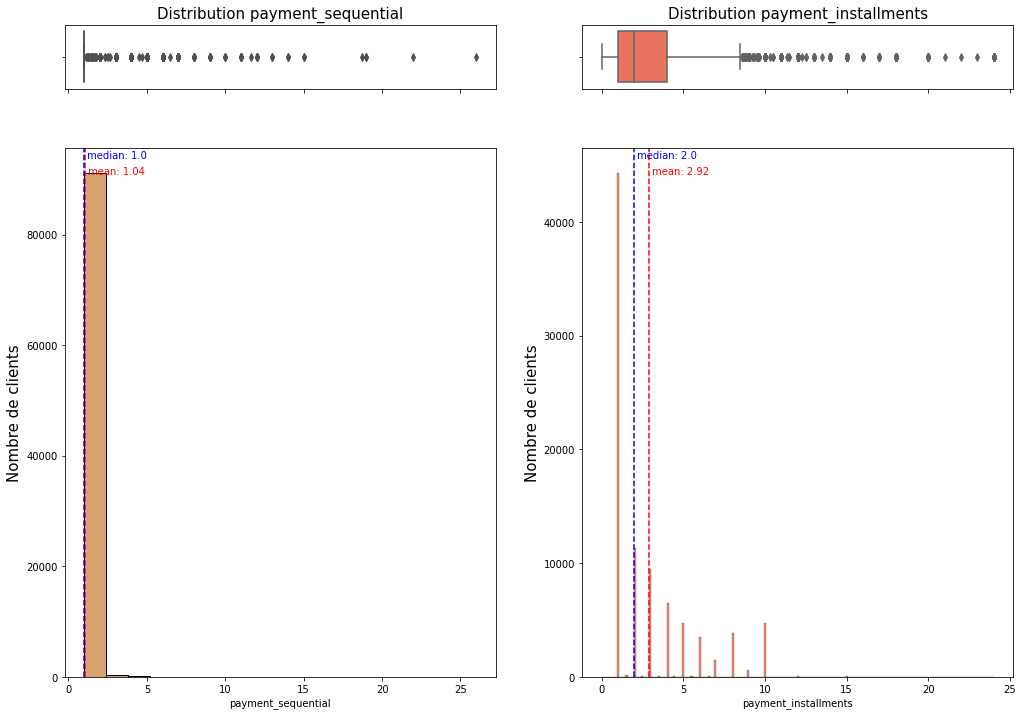

In [ ]:
name_col1 = ['payment_sequential', 'payment_installments']
title1 = ['Distribution payment_sequential', 'Distribution payment_installments']
colors1 =  ['peru', 'tomato']
dist_box_hist(df_final, name_col1, title1, colors1)

Pour la variable payment_sequential on va avoir :
- Un mode de paiement moyen allant de 1 à 26. C'est une valeur extrème mais atypique le client a payé ses achats qu'avec des bon d'achats.
- La majorité des clients vont principalement avoir un mode de paiement

Pour la variable payment_installments on va avoir :
- Un paiement en plusieurs fois allant de 0 à 24 fois
- Un paiement en plusieurs fois moyen de 3 fois et median de 2 fois
- 50% des clients vont payer entre 1 fois et 4 fois

#<a name = "analyse1">Analyse bivarie</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour l'analyse bivariée je vais commencer par voir s'il existe une relation linéaire entre les variables

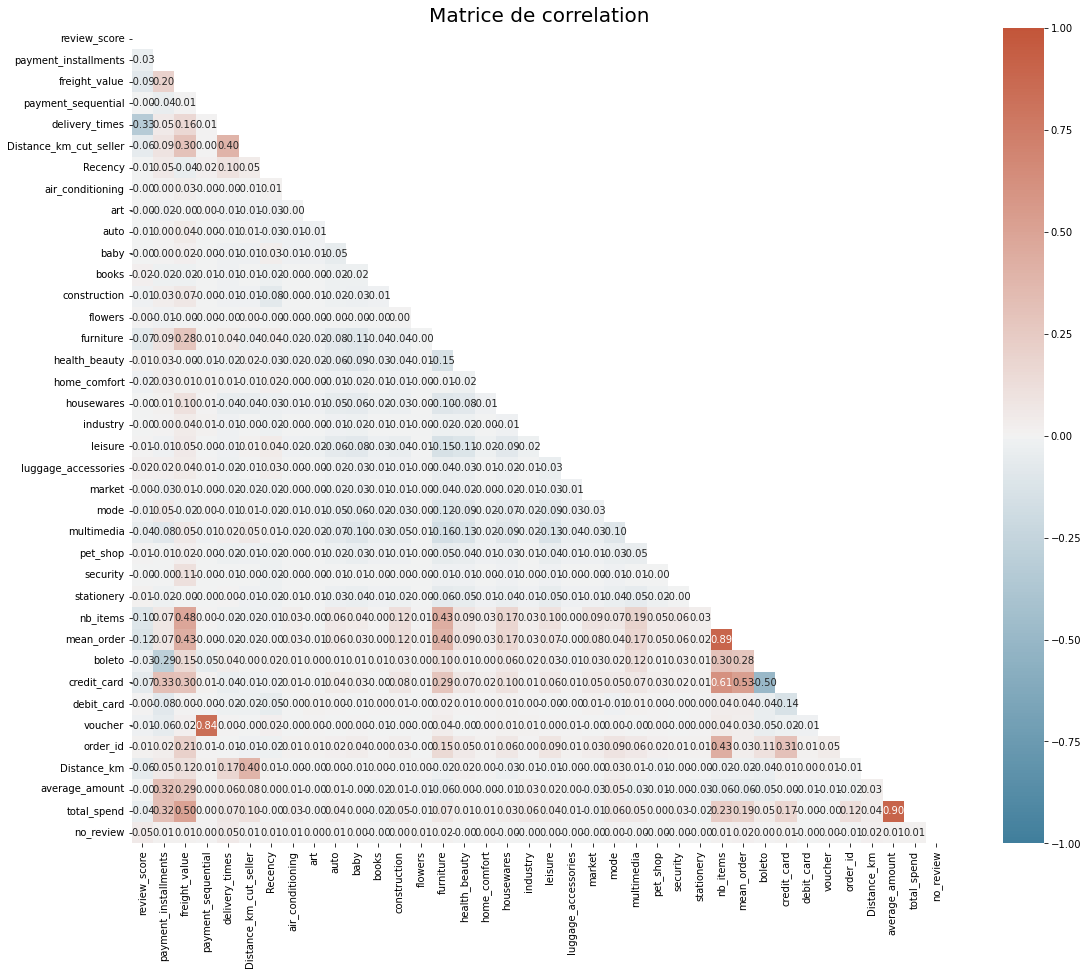

In [ ]:
corr = df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize = (20,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, vmax = 1, vmin = -1, annot=True, fmt='.2f')
plt.title('Matrice de correlation', size = 20)
plt.show()

Pour avoir une meilleure visualisation je vais enlever toutes les variables qui représentent le nombre d'achat par catégorie et qui ont aucune relation linéaire.

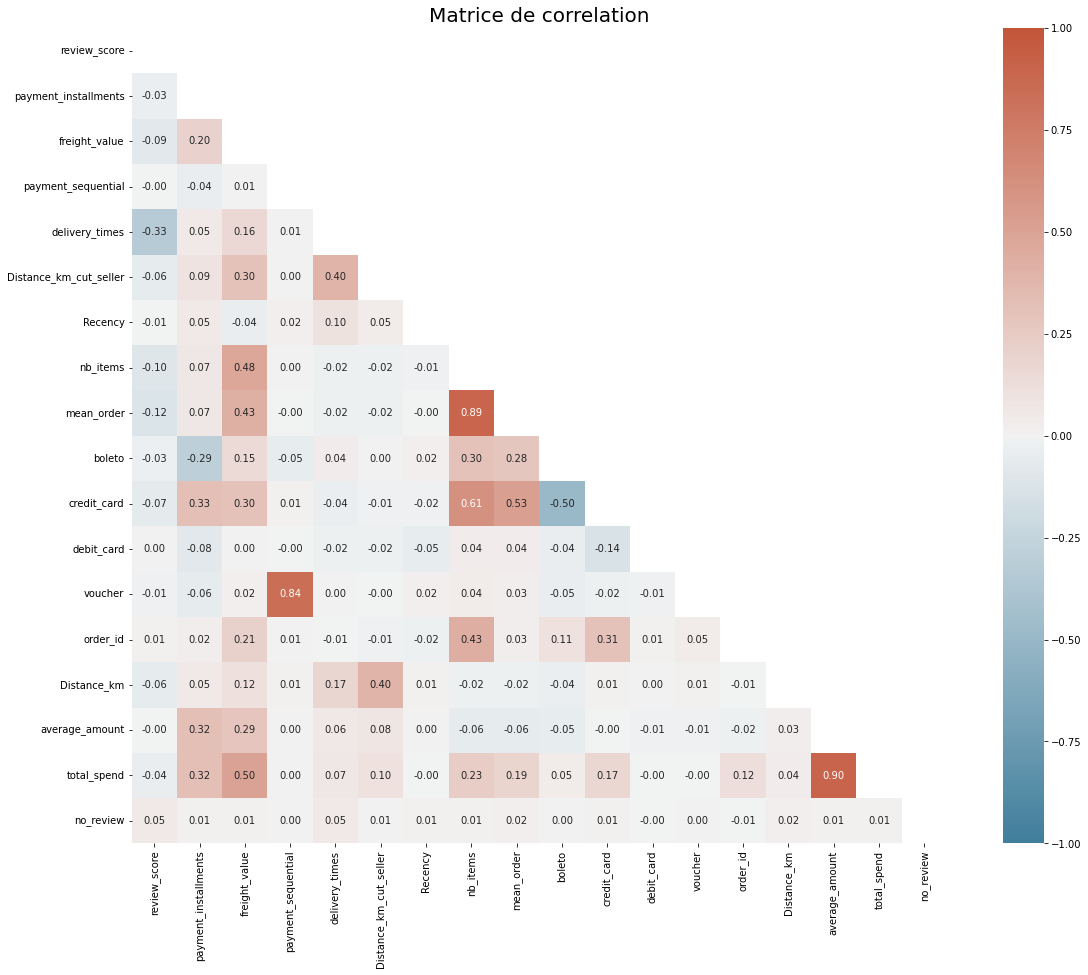

In [ ]:
df_corr = df_final.drop(['air_conditioning', 'art', 'auto',
       'baby', 'books', 'construction', 'flowers', 'furniture',
       'health_beauty', 'home_comfort', 'housewares', 'industry', 'leisure',
       'luggage_accessories', 'market', 'mode', 'multimedia', 'pet_shop',
       'security', 'stationery'], axis = 1)
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize = (20,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, vmax = 1, vmin = -1, annot=True, fmt='.2f')
plt.title('Matrice de correlation', size = 20)
plt.show()

Au vu de la matrice de corrélation on remarque que :
- Il existe une forte relation linéaire positive entre total_spend et average_amount
- Il existe une forte relation linéaire positive entre voucher et payment_sequential
- Il existe une forte relation linéaire positive entre mean_order et nb_items
- Il existe quelques relations linéaires positives et négatives modérées

Au vu de la fréquence d'achat des clients, il est normal d'avoir un coefficient élevé entre (totel_spend et average_amount) et (mean_order et nb_items) ce score sera amené a évoluer dans le temps.  

In [ ]:
os.remove("/content/drive/MyDrive/P5 segmentation/data/olist_final.csv")
df_final.to_csv('/content/drive/MyDrive/P5 segmentation/data/olist_final.csv', index = False) 